# Introduction-to-CORD-19

> In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 59,000 scholarly articles, including over 47,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.



> Develop text and data mining tools that can help the medical community develop answers to high priority scientific questions.


# # Loading Libraries

[[[[[](http://)](http://)](http://)](http://)](http://)# Preprocessing 
<hr>

## Converting JSON Data to clean Data Frame

In [ ]:
path = '/kaggle/input/CORD-19-research-challenge/'
filenames = glob.glob(f'{path}/**/*.json', recursive=True)
print('There are ' + str(len(filenames)) + ' Research papers')

In [ ]:
filenames = filenames[:50]

In [ ]:
import json
biorxivfiles = []
for file in filenames:
    files = json.load(open(file,'rb'))
    biorxivfiles.append(files)

In [ ]:
body_text = []
paper_id = []
abstract = []
for i in range(len(biorxivfiles)):
    lis1=[]
    for data in biorxivfiles[i]['body_text']: 
         lis1.append(data['text'])
            
    lis1 = '\n'.join(lis1)
    
    paper_id.append(biorxivfiles[i]['paper_id'])
            
    lis2=[]
    for data in biorxivfiles[i]['abstract']:
         lis2.append(data['text'])
    
    lis2= '\n'.join(lis2)
    
    
    body_text.append(lis1)
    abstract.append(lis2)

In [ ]:
df = pd.DataFrame(list(zip(paper_id,body_text, abstract)), 
               columns =['paper_id','body_text', 'abstract']) 

In [ ]:
df.head()


### Importing DataFrame

In [ ]:
#https://www.kaggle.com/danielwolffram/cord-19-create-dataframe
data = pd.read_csv('/kaggle/input/cord-2019df/cord19_df.csv')

In [ ]:
data.shape

There are totally 44860 news articles

In [ ]:
data.columns

## Source - Counts of articles from different sources

In [ ]:
data['source'].value_counts()

Filtering MEDRXIV

In [ ]:
meddf = data[data['source'] == 'biorxiv']
meddf = meddf.reset_index()

# Clustering Similar Research Articles

## 1. Preprocess Text Data


>SciSpacy - custom tokenizer that adds tokenization rules on top of spaCy's rule-based tokenizer  trained on biomedical data.


>Removed Numbers ,  Punctuations , Spaces 

> Removed words with Word length <=2

> Stop Word Removal - Extended list with customized words(doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI’)

> Lemmatization

In [ ]:
# https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal'
]


In [ ]:
# SciSpacy model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 200000

In [ ]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence.lower()) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)<=2)]

In [ ]:
# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

## 2. Tf-IDF Features

Convert a collection of raw documents to a matrix of TF-IDF features. represent how important a specific word or phrase is to a given document.

Term Frequency = how frequently a term occurs in a document
Inverse Document Frequency, which measures how important a term.
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Features = TF * IDF

Parameters:

min_df - When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
ngram_range=(1, 2) - Both Unigrams and Trigrams

In [ ]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, tokenizer = spacy_tokenizer,
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
X = tfv.fit_transform(meddf['body_text'])

In [ ]:
X.shape

In [ ]:
X.toarray()

## Kmeans



It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum

the sum of distances of observations from their cluster centroids - Within-Cluster-Sum-of-Squares (WCSS)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 20)

### Fitting with 12 clusters

In [ ]:

clusters = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20).fit_predict(X)


# 3.Dimensionality Reduction

## A. Principal Component Analysis
Dimensionality Reduction helps to reduce the number of features and increase training speed.Also,It helps to visualize the high dimensional data in 2D space and detect clusters.

Two main approaches to dimensionality reduction : (projection and Manifold Learning)

PCA is popular dimension reduction method that identifies hyperplane that has maximum variance and projects data onto it.

Identifies the hyperplane that lies closest to the data, and then it projects the data onto it. Selects the axis that preserves the maximum amount of variance , axis that minimizes the mean squared distance between the original dataset and its projection onto that axis.


 ## B. Singular Valued Decomposition
 
 (SVD) helps to find principal components that can decompose the training set matrix X into the matrix multiplication of three matrices U Σ V⊺, where V contains the unit vectors that define all the principal component.

 
 ## C. t-SNE
 
 Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space.


In [ ]:
#X.shape

In [ ]:
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)

In [ ]:
X_reduced.shape

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=40).fit_transform(X_reduced)

In [ ]:
X_embedded.shape

# Clustering Similar Research Articles using TSNE and Kmeans.

In [ ]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5", "#e3be38", 
                     "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31"])

In [ ]:
plot_kmeans = figure(plot_width = 1300, plot_height = 500, 
                       title = "k-means clustering of Covid Research Articles",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

source = ColumnDataSource(data = dict(x =  X_embedded[:,0], y = X_embedded[:,1],
                                      color = colormap[clusters],
                                      desc= clusters, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']))

plot_kmeans.scatter(x = "x", y = "y", color = "color", source = source)
hover = plot_kmeans.select(dict(type = HoverTool))
plot_kmeans.sizing_mode = "scale_both"
plot_kmeans.sizing_mode = "stretch_width"
hover.tooltips = {"titles": "@titles", "links": "@links", "labels": "@labels"}
show(plot_kmeans)



In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X, clusters, tfv.get_feature_names(), 10)

# Topic Modelling

Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

LDA converts this Document-Term Matrix into two lower dimensional matrices – M1 and M2.

M1 is a document-topics matrix .
M2 is a topic – terms matrix with dimensions (N,  K) and (K, M) respectively

 N is the number of documents, K is the number of topics and M is the vocabulary size.

LDA makes use of sampling techniques in order to improve  topic word and document topic distributions


## Preparing Document-Term Matrix

In [ ]:
docs = [spacy_tokenizer(doc) for doc in meddf['body_text']]
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=20)
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(viz)

# Text Summarization

Automatic text summarization is the task of producing a concise and fluent summary while preserving key information content and overall meaning.

** Extractive Summarization: 

Identify the important sentences or phrases from the original text and extract only those from the text.



2. Converting text data to  vector representation using word embeddings.
Word2Vec

Dense vectors
   short (length 50-1000)
• dense (most elements are non-zero)
• Representation is created by training a classifier to distinguish nearby and faraway Words

neural language modeling
A word w near apricot  Acts as gold ‘correct answer’ to the question
• “Is word w likely to show up near apricot?

Training sentence:

Example Sentence:

... lemon, a tablespoon of apricot jam a pinch ...
• c1 c2 target c3 c4

1. Treat the target word and a neighboring context word as
positive examples.
2. Randomly sample other words in the lexicon to get negative
samples

3. Use logistic regression to train a classifier to distinguish those
two cases
4. Use the weights as the embeddings




3. Similarities between sentence vectors are then calculated and stored in a matrix

4. The similarity matrix is then converted into a graph, with sentences as vertices and similarity scores as edges, for sentence rank calculation

Finally, a certain number of top-ranked sentences from the final summary



In [ ]:
print(summarize(data['body_text'][0], word_count=150))

## Abstractive Summarization

These methods use advanced NLP techniques and deep learning to generate an entirely new summary

Recurrent Neural Networks



Recurrent neural networks (RNN) is a popular model that performs prediction based on sequential information existing in the input.

 It has been widely used for natural language processing problems as a sentence is essentially a sequence combination of words.





A RNN takes the first word (x<1>) and feeds it into a neural network layer which predicts an output (y’<1>). This process is repeated until the last time. 
Y<2> - predict not  only using X<2>,takes info from previous Inputs

Activation from previous layer is passed on to next layer

Scans data from left to Right and parameters shared between each input and hidden layer (Wax), every timestep (Waa) and between the hidden layer and the output (Wya).



Consider the two sentences: which two sentences is grammatically correct? 
The cat, which already ate a bunch of food, was full.
The cat, which already ate a bunch of food, were full.
( first one )

Basic RNNs are not good at capturing long term dependencies. This is because during backpropagation, gradients from an output y would have a hard time propagating back to affect the weights of earlier layers. So, in basic RNNs, the output is highly affected by inputs closer to that word.

Recurrent Neural Networks suffer from short-term memory. If a sequence is long enough, they’ll have a hard time carrying information from earlier time steps to later ones. So if you are trying to process a paragraph of text to do predictions, RNN’s may leave out important information from the beginning.




LSTM solves the problem of vanishing gradients with help of Gates that regulate the flow of information that capture long term dependencies. 

LSTM has 3 gates that helps to control the information flow in a cell namely 

Forget gate
Input gate 
Output gate

The Encoder-Decoder architecture is mainly used to solve the sequence-to-sequence (Seq2Seq) problems where the input and output sequences are of different lengths.

GRU or LSTM are preferred as the encoder and decoder components.

Encoder-Decoder - Training phase

Encoder processes the information at every timestep and captures the contextual information present in the input sequence
The decoder is trained to predict the next word in the sequence given the previous word.

Inference phase

Model is tested on new source sequences for which the target sequence is unknown.

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")
summarizer(meddf['body_text'][0]
           
           , min_length=5, max_length=20)

# *Searching Related Articles using Sentence Transformers

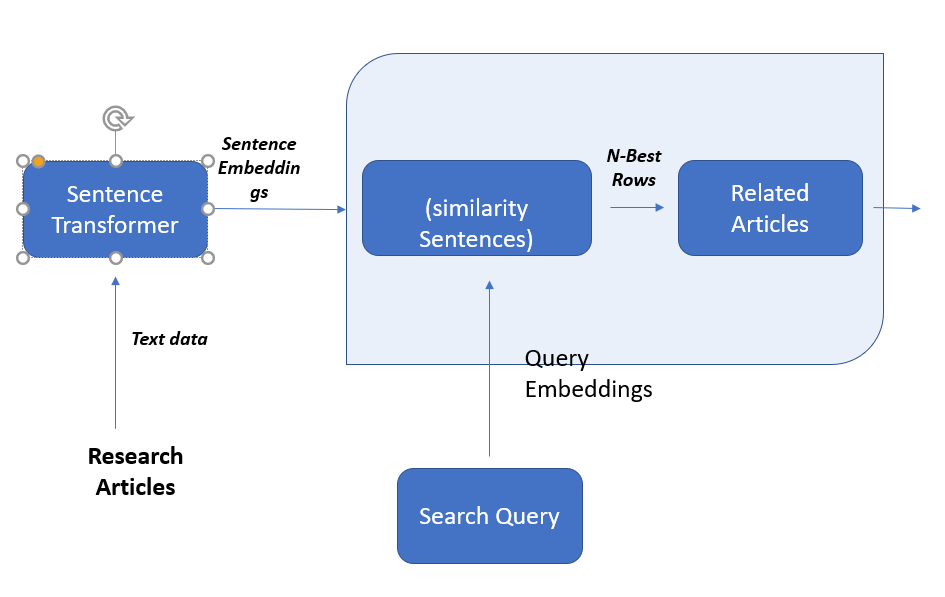




The Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution

Transformer is to handle the dependencies between input and output with attention and recurrence completely.


BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text.

BERT stands for Bidirectional Encoder Representations for Transformers, which is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning.

In [ ]:
meddf = data[data['source'] == 'biorxiv']
corpus = meddf['body_text'].values.tolist()
corpus_embeddings = embedder.encode(corpus)

In [ ]:
queries = ['antiviral covid-19 success treatment','virus detected from animals?']
query_embeddings = embedder.encode(queries)

In [ ]:
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    for idx, distance in results[0:10]:
        print(meddfr['paper_id'][idx],meddfr['url'][idx],meddfr['url'][idx],meddfr['abstract'][idx], "(Score: %.4f)" % (1-distance))

# Building App using Plotly Dash

## App

In [ ]:
#app.py
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from data import get_similar_sentences
import flask
import dash_table
import pandas as pd

queries = ['Range of incubation periods for the disease in humans', 'antiviral covid-19 success treatment','virus detected from animals?', 'risk of fatality among symptomatic hospitalized patients']

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([

html.H1('HAP880 Project - COVID-19 Research Semantic Search ',style={'textAlign': 'center',"background": "lightblue"}),


dcc.Input(id='my-id', value='Range of incubation periods for the disease in humans',
                  type='search',
                  placeholder="Ask your Query here like Range of incubation periods for the disease in humans or What are the rapid molecular diagnostics for COVID-19",
                  style={'display': 'flex', 'verticalAlign': "middle", 'justifyContent': 'center', 'width': '60%',
                         'textAlign': 'center'}),


html.Div([
                dcc.Tabs(id='tabs-example', value='tab-1', children=[
                    dcc.Tab(label='Research Article Search', value='tab-1',style={'textAlign': 'center','font-size': '32px',"background": "lightblue"}),
                    dcc.Tab(label='Topic Modelling of Articles', value='tab-2',style={'textAlign': 'center','font-size': '32px',"background": "lightblue"}),
dcc.Tab(label='Clustering of Articles', value='tab-3',style={'textAlign': 'center','font-size': '32px',"background": "lightblue"})
                ]),
                html.Div(id='tabs-example-content')
                ]),


])


@app.callback(Output('tabs-example-content', 'children'),
              [Input('tabs-example', 'value')])
def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
            html.Div(children=[html.Table(id='my-div')])

        ])
    elif tab == 'tab-2':
        return html.Div([
            html.Iframe(src=app.get_asset_url('scispacylda.html'),
                        style=dict(position="absolute",width="100%", height="100%"))
        ])
    elif tab == 'tab-3':
        return html.Div([
            html.Iframe(src=app.get_asset_url('tsne.html'),
                        style=dict(position="absolute",width="100%", height="100%"))
        ])











@app.callback(
    Output(component_id='my-div', component_property='children'),
    [Input(component_id='my-id', component_property='value')]
)

def update_output_div(input_value):
    queries = input_value
    dataframe = get_similar_sentences([queries])
    rows = []
    for i in range(len(dataframe)):
        row = []
        for col in dataframe.columns:
            value = dataframe.iloc[i][col]
            # update this depending on which
            # columns you want to show links for
            # and what you want those links to be
            if col == 'url':
                cell = html.Td(html.A(href=value, children=value))
            else:
                cell = html.Td(children=value)
            row.append(cell)
        rows.append(html.Tr(row))
    return html.Table(
        # Header
        [html.Tr([html.Th(col) for col in dataframe.columns],style={'color':'#FFFFFF',
                                                'background-color':'#76e8a8'})] +

        rows,
    style = {'color': '#FFFFFF',
             'background-color': '#76e8a8'}
    )



if __name__ == '__main__':
    app.run_server(host='10.193.124.234')

Data

In [ ]:
#data.py

from sentence_transformers import SentenceTransformer
import scipy.spatial
import pandas as pd
import joblib
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
import dash_html_components as html


meddfr = pd.read_csv('/home/gn/semanticsearch/data/cord2019.csv')
corpus = meddfr['body_text'].values.tolist()

corpus_embeddings = joblib.load('/home/gn/semanticsearch/hap_semanticsearch/corpus_embeddingsfilfull.sav')
#filename = 'corpus_embeddings.sav'
#joblib.dump(corpus_embeddings, filename)


def get_similar_sentences(queries):
    query_embeddings = embedder.encode(queries)

    closest_n = 5
    res=[]
    rows=[]
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])

        print("\n\n======================\n\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences from similar")

        for idx, distance in results[0:closest_n]:
            #print(meddfr['paper_id'][idx],meddfr['url'][idx],meddfr['url'][idx],meddfr['abstract'][idx], "(Score: %.4f)" % (1-distance))
            res.append([meddfr['title'][idx],meddfr['url'][idx],meddfr['publish_time'][idx], "(Score: %.4f)" % (1-distance)])
    df = pd.DataFrame(res,columns = ['title','url','publish_date','score'])
    return df